# ST1504 Part C Technical Paper

## RNN, LSTM and GRU models applied to Sentiment Analysis for comparison on efficiency and test accuracy

### Name: Haja Amir Rahman
### Class: DAAA/FT?2B/06
### Admin Number: P2100803

### References: 

- [Fashion-Mnist Dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data)
- [Using GloVe and Pretrained Embedding layers](https://haochen23.github.io/2020/01/nlp-rnn-sentiment.html#.Y3sIcXZByUk)
- [GloVe Model Loading](https://www.kaggle.com/datasets/fullmetal26/glovetwitter27b100dtxt)
- [Understanding Embedding Layers in Keras and GloVe](https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce )

In [77]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [78]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN, Activation, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, Flatten, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# https://haochen23.github.io/2020/01/nlp-rnn-sentiment.html#.Y3sIcXZByUk

In [79]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# data = pd.read_csv("https://raw.githubusercontent.com/haochen23/nlp-rnn-lstm-sentiment/master/training.1600000.processed.noemoticon.csv", header=None, encoding='cp437')
# print("The shape of the original dataset is {}".format(data.shape))
# data

raw = pd.read_csv('data/Reddit_Data.csv')
raw

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [80]:
raw['category'].value_counts()

 1    15830
 0    13142
-1     8277
Name: category, dtype: int64

In [81]:
NUM = 8277

positive = raw[raw['category']==1].sample(8277)
neutral = raw[raw['category']==0].sample(8277)
negative = raw[raw['category']==-1].sample(8277)

data = pd.concat([positive, neutral, negative], axis=0).sample(frac=1)
# positive.shape, neutral.shape, negative.shape

data

,clean_comment,category
28310,have intention escalation but are fully prepa...,-1
13355,god this southie northie bullshit again southi...,1
1991,alonso going fucking ham,-1
31008,you just gonna ignore the fact that pakistani ...,-1
20685,did bjp issue directive rape and murder people...,-1
...,...,...
35043,odd days modi destroying environment giving la...,-1
30875,this resembling cultish characteristics,0
27207,hello would you kind and send digital copy you...,1
21922,goes tell you how pathetic grossly incompetent...,-1


In [82]:
def load_glove_model(glove_file, encoding='iso-8859-1'):
    print("[INFO]Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r', encoding=encoding) as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embeddings = [float(val) for val in split_line[1:]]
            model[word] = embeddings
    print("[INFO] Done...{} words loaded!".format(len(model)))
    return model
# adopted from utils.py
nlp = spacy.blank("en")

def remove_stopwords(sentence):
    '''
    function to remove stopwords
        input: sentence - string of sentence
    '''
    new = []
    # tokenize sentence
    sentence = nlp(sentence)
    for tk in sentence:
        if (tk.is_stop == False) & (tk.pos_ !="PUNCT"):
            new.append(tk.string.strip())
    # convert back to sentence string
    c = " ".join(str(x) for x in new)
    return c


def lemmatize(sentence):
    '''
    function to do lemmatization
        input: sentence - string of sentence
    '''
    sentence = nlp(sentence)
    s = ""
    for w in sentence:
        s +=" "+w.lemma_
    return nlp(s)

def sent_vectorizer(sent, model):
    '''
    sentence vectorizer using the pretrained glove model
    '''
    sent_vector = np.zeros(200)
    num_w = 0
    for w in sent.split():
        try:
            # add up all token vectors to a sent_vector
            sent_vector = np.add(sent_vector, model[str(w)])
            num_w += 1
        except:
            pass
    return sent_vector

In [83]:
data_X = data['clean_comment'].to_numpy().astype('str')
data_y = data['category']
data_y = pd.get_dummies(data_y).to_numpy()

data_X.shape, data_y.shape

((24831,), (24831, 3))

### Loading GloVe Model

In [84]:
# load the glove model
glove_model = load_glove_model("glove.twitter.27B.200d.txt", encoding='utf-8')
# number of vocab to keep
max_vocab = 18000
# length of sequence that will generate
max_len = 15

tokenizer = Tokenizer(num_words=max_vocab)

[INFO]Loading GloVe Model...
[INFO] Done...1193514 words loaded!


### Tokenizing 

In [85]:
tokenizer.fit_on_texts(data_X)
sequences = tokenizer.texts_to_sequences(data_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_keras = pad_sequences(sequences, maxlen=max_len, padding="post")

data_keras.shape

Found 43994 unique tokens.


(24831, 15)

## Train-test-split

In [86]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_keras, data_y, test_size = 0.3, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((17381, 15), (7450, 15), (17381, 3), (7450, 3))

In [87]:
# calculate number of words
nb_words = len(tokenizer.word_index) + 1
print(f"Number of words: {nb_words}")

# obtain the word embedding matrix
embedding_matrix = np.zeros((nb_words, 200))

for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Number of words: 43995
Null word embeddings: 13071


In [90]:
# adopted from sent_tran_eval.py
def build_model(nb_words, rnn_model="SimpleRNN", embedding_matrix=None):
    '''
    build_model function:
    inputs: 
        rnn_model - which type of RNN layer to use, choose in (SimpleRNN, LSTM, GRU)
        embedding_matrix - whether to use pretrained embeddings or not
    '''
    model = Sequential()
    # add an embedding layer
    if embedding_matrix is not None:
        model.add(Embedding(nb_words, 
                        200, 
                        weights=[embedding_matrix], 
                        input_length= max_len,
                        trainable = False))
    else:
        model.add(Embedding(nb_words, 
                        200, 
                        input_length= max_len,
                        trainable = False))
        
    # add an RNN layer according to rnn_model
    if rnn_model == "SimpleRNN":
        model.add(SimpleRNN(256))
      
    elif rnn_model == "LSTM":
        model.add(LSTM(256))
    else:
        model.add(GRU(256))

    model.add(Dense(512,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                optimizer='rmsprop',
                metrics=['accuracy'])
    return model

## RNN Model

In [91]:
model_rnn = build_model(nb_words, "SimpleRNN", embedding_matrix)
model_rnn.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_rnn.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_rnnAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_rnnLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
model_rnn_history = model_rnn.fit(x_train, y_train, 
                                                epochs=30, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])
model_rnn.summary()
predictions = model_rnn.predict(x_test)
predictions = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), predictions))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 15, 200)           8799000   
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 256)               116992    
                                                                 
 dense_49 (Dense)            (None, 512)               131584    
                                                                 
 dense_50 (Dense)            (None, 512)               262656    
                                                                 
 dense_51 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 9,311,771
Trainable params: 512,771
Non-trainable params: 8,799,000
_________________________________________________________________
Epoch 1/30
544/544 [=================

In [92]:
# evaluating baseline coarse model
print(model_rnn.evaluate(x_test, y_test))
model_rnn.load_weights('tmp/checkpoint/model_rnnAcc.hdf5')
scoreAcc = model_rnn.evaluate(x_test, y_test)
model_rnn.load_weights('tmp/checkpoint/model_rnnLoss.hdf5')
scoreLoss = model_rnn.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

233/233 [==============================] - 2s 8ms/step - loss: 1.7323 - accuracy: 0.6534
[1.7323493957519531, 0.6534228324890137]
233/233 [==============================] - 2s 8ms/step - loss: 0.8573 - accuracy: 0.6142
Best Acc Test Loss: 1.1107232570648193
Best Acc Test Accuracy: 65.5 %
Best Loss Test Loss: 0.8573042154312134
Best Loss Test Accuracy: 61.419999999999995 %


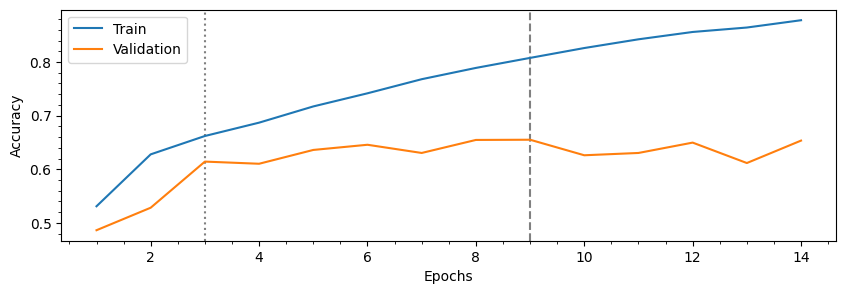

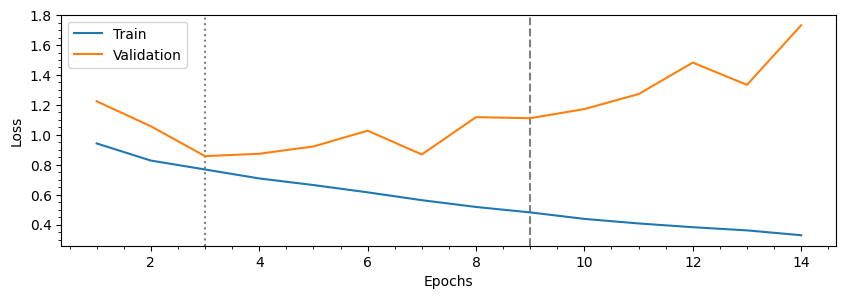

In [93]:
max_val_acc_epoch = np.argmax(list(model_rnn_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(model_rnn_history.history['val_loss']))+1
epochs = range(1, len(model_rnn_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_rnn_history.history['accuracy'], label='Train')
plt.plot(epochs,model_rnn_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_rnn_history.history['loss'], label='Train')
plt.plot(epochs,model_rnn_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [94]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model_rnn, legend=True)

In [95]:
# model_rnn.save_weights("./models/rnn-model.h5")

## LSTM Model

In [96]:
model_lstm = build_model(nb_words, "LSTM", embedding_matrix)
model_lstm.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_lstm.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_lstmAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_lstmLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
model_lstm_history = model_lstm.fit(x_train, y_train, 
                                                epochs=30, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])

predictions = model_lstm.predict(x_test)
predictions = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), predictions))


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 15, 200)           8799000   
                                                                 
 lstm_8 (LSTM)               (None, 256)               467968    
                                                                 
 dense_52 (Dense)            (None, 512)               131584    
                                                                 
 dense_53 (Dense)            (None, 512)               262656    
                                                                 
 dense_54 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 9,662,747
Trainable params: 863,747
Non-trainable params: 8,799,000
_________________________________________________________________
Epoch 1/30
538/544 [=================

In [97]:
# evaluating baseline coarse model
print(model_lstm.evaluate(x_test, y_test))
model_lstm.load_weights('tmp/checkpoint/model_lstmAcc.hdf5')
scoreAcc = model_lstm.evaluate(x_test, y_test)
model_lstm.load_weights('tmp/checkpoint/model_lstmLoss.hdf5')
scoreLoss = model_lstm.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

233/233 [==============================] - 1s 4ms/step - loss: 1.5763 - accuracy: 0.7323
[1.5762856006622314, 0.7323489785194397]
233/233 [==============================] - 1s 4ms/step - loss: 0.6484 - accuracy: 0.7133
Best Acc Test Loss: 0.681652307510376
Best Acc Test Accuracy: 74.55000000000001 %
Best Loss Test Loss: 0.6483654975891113
Best Loss Test Accuracy: 71.33 %


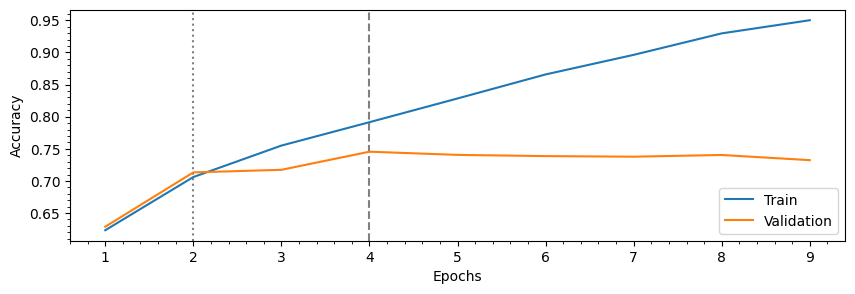

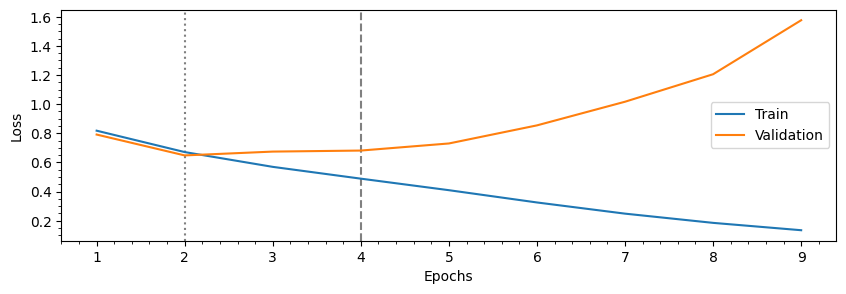

In [98]:
max_val_acc_epoch = np.argmax(list(model_lstm_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(model_lstm_history.history['val_loss']))+1
epochs = range(1, len(model_lstm_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_lstm_history.history['accuracy'], label='Train')
plt.plot(epochs,model_lstm_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_lstm_history.history['loss'], label='Train')
plt.plot(epochs,model_lstm_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [99]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model_lstm, legend=True)

In [100]:
# model_lstm.save_weights("models/model-lstm.h5")

## GRU Model 

In [101]:
model_gru = build_model(nb_words, "GRU", embedding_matrix)
model_gru.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_gru.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_gruAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_gruLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
model_gru_history = model_gru.fit(x_train, y_train, 
                                                epochs=30, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])

predictions = model_gru.predict(x_test)
predictions = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), predictions))


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 15, 200)           8799000   
                                                                 
 gru_6 (GRU)                 (None, 256)               351744    
                                                                 
 dense_55 (Dense)            (None, 512)               131584    
                                                                 
 dense_56 (Dense)            (None, 512)               262656    
                                                                 
 dense_57 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 9,546,523
Trainable params: 747,523
Non-trainable params: 8,799,000
_________________________________________________________________
Epoch 1/30
539/544 [=================

In [102]:
# evaluating baseline coarse model
print(model_gru.evaluate(x_test, y_test))
model_gru.load_weights('tmp/checkpoint/model_gruAcc.hdf5')
scoreAcc = model_gru.evaluate(x_test, y_test)
model_gru.load_weights('tmp/checkpoint/model_gruLoss.hdf5')
scoreLoss = model_gru.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

233/233 [==============================] - 1s 4ms/step - loss: 2.5063 - accuracy: 0.7499
[2.5062625408172607, 0.7499328851699829]
233/233 [==============================] - 1s 4ms/step - loss: 0.6210 - accuracy: 0.7334
Best Acc Test Loss: 2.1408281326293945
Best Acc Test Accuracy: 75.74 %
Best Loss Test Loss: 0.6209526658058167
Best Loss Test Accuracy: 73.34 %


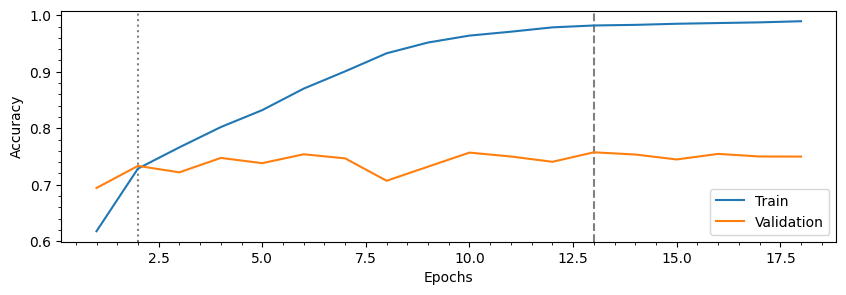

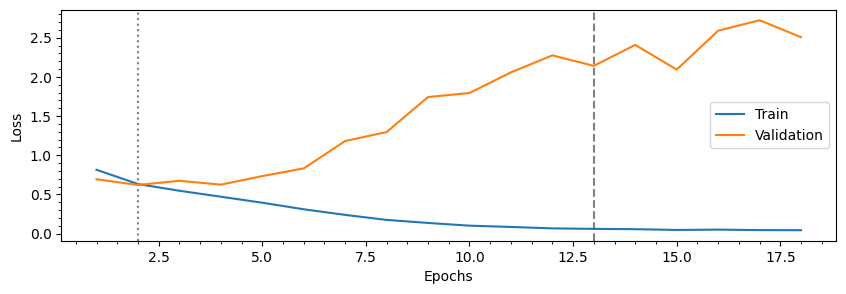

In [103]:
max_val_acc_epoch = np.argmax(list(model_gru_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(model_gru_history.history['val_loss']))+1
epochs = range(1, len(model_gru_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_gru_history.history['accuracy'], label='Train')
plt.plot(epochs,model_gru_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_gru_history.history['loss'], label='Train')
plt.plot(epochs,model_gru_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [104]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model_gru, legend=True)

In [105]:
# model_gru.save_weights("models/model-gru.h5")

### Using a non-deep learning model (TFIDF vectorization) and other effective, traditional machine learning models

In [106]:
data

,clean_comment,category
28310,have intention escalation but are fully prepa...,-1
13355,god this southie northie bullshit again southi...,1
1991,alonso going fucking ham,-1
31008,you just gonna ignore the fact that pakistani ...,-1
20685,did bjp issue directive rape and murder people...,-1
...,...,...
35043,odd days modi destroying environment giving la...,-1
30875,this resembling cultish characteristics,0
27207,hello would you kind and send digital copy you...,1
21922,goes tell you how pathetic grossly incompetent...,-1


In [107]:
from sklearn.model_selection import train_test_split

x = data['clean_comment'].astype('str')
y = data['category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

x_train_vec.shape, x_test_vec.shape 

((19864, 10000), (4967, 10000))

## RandomForestClassifier

In [109]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(x_train_vec, y_train)
model_rf.score(x_test_vec, y_test)

predictions = model_rf.predict(x_test_vec)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.76      0.69      0.72      1668
           0       0.78      0.91      0.84      1658
           1       0.79      0.73      0.76      1641

    accuracy                           0.78      4967
   macro avg       0.77      0.78      0.77      4967
weighted avg       0.77      0.78      0.77      4967



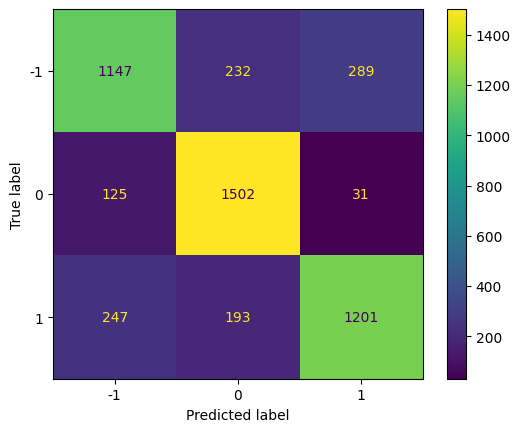

In [110]:
cm = confusion_matrix(y_test, predictions, labels=model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
disp.plot()


## Logistic Regression

In [111]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(x_train_vec, y_train)
model_lr.score(x_test_vec, y_test)

predictions = model_lr.predict(x_test_vec)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.86      0.79      0.83      1668
           0       0.82      0.93      0.87      1658
           1       0.86      0.81      0.83      1641

    accuracy                           0.84      4967
   macro avg       0.85      0.84      0.84      4967
weighted avg       0.85      0.84      0.84      4967



c:\Users\P2100803\.conda\envs\gpu\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


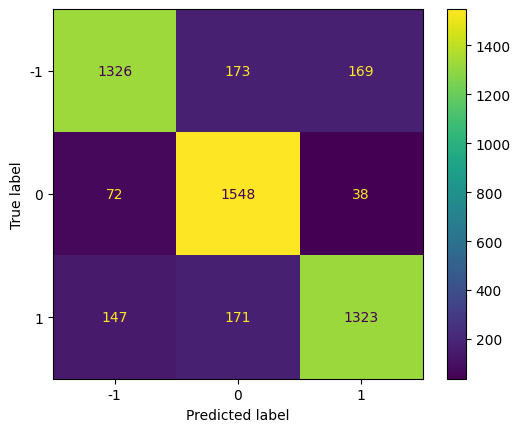

In [112]:
cm = confusion_matrix(y_test, predictions, labels=model_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)
disp.plot()
